In [1]:
import qrcode

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
from datetime import datetime

import os

import tkinter as tk
from tkinter import filedialog as fd

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import requests

import collections

In [4]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
ruta

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

## Leer catastro

In [5]:
# open file dialog
#root = tk.Tk()
#root.attributes('-topmost', True)
#root.iconify()
#file_name = fd.askopenfilename(parent=root, filetypes=[(".shp", ".shp")])
#root.destroy()


In [8]:
cat_filename = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - CATASTRO\Catastro\CATASTRO 2024\catastro080824.shp'
#cat_filename = 'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\INFORMACION GENERAL\\CATASTRO\\NUEVO\\catastro140624.shp'
cat_filename

'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - CATASTRO\\Catastro\\CATASTRO 2024\\catastro080824.shp'

In [9]:
# leer el .shp seleccionado
data_catastro = gpd.read_file(cat_filename)

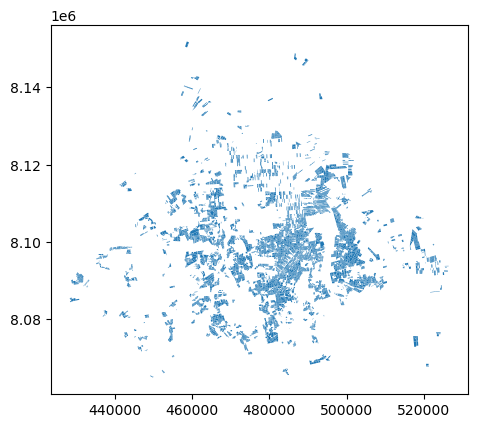

In [10]:
data_catastro.plot()
plt.show()

In [11]:
data_catastro

,id,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,variedad,soca,zona,textura,cultivo,zafra,financia,fs,fc,area,municipio,layer,path,geometry
0,00008090000L10,809,PROP.CINDA MONTAÑO,42047,TORREJON MONTAÑO ERICK FERNANDO,L10,RB2,0,131,F,canha,2024,IAG,2023-05-10,None,1.06,None,catastroguabira,D:/DATOS 2024/MONITOREO QUEMA/catastroguabira.shp,"POLYGON ((483705.780 8091547.831, 483741.382 8..."
1,000017970000L3,1797,CHOROLQUE--CALVIMONTES EVELYN,2913,CALVIMONTES VARGAS ZAIRA EVELYN,L3,UCG9020,0,304,FA,canha,2024,None,2023-06-20,None,2.26,None,catastroguabira,D:/DATOS 2024/MONITOREO QUEMA/catastroguabira.shp,"POLYGON ((477827.271 8119731.232, 477929.141 8..."
2,00008090000L3.1,809,PROP.CINDA MONTAÑO,8816,MONTANO GUTIERREZ CINDA,L3.1,UCG9020,0,131,F,canha,2024,IAG,2023-05-15,None,4.15,None,catastroguabira,D:/DATOS 2024/MONITOREO QUEMA/catastroguabira.shp,"POLYGON ((483066.890 8091686.193, 483035.880 8..."
3,000015390000L14,1539,MERCEDES Y PAULINA,41967,ANZE CUAJIRA RUTTY,L14,UCG9020,0,102,FY,canha,2024,IAG,2023-05-10,None,17.42,None,catastroguabira,D:/DATOS 2024/MONITOREO QUEMA/catastroguabira.shp,"POLYGON ((504569.915 8104727.961, 504156.747 8..."
4,00008090000L9,809,PROP.CINDA MONTAÑO,42047,TORREJON MONTAÑO ERICK FERNANDO,L9,RB2,0,131,F,canha,2024,IAG,2023-05-15,None,1.43,None,catastroguabira,D:/DATOS 2024/MONITOREO QUEMA/catastroguabira.shp,"POLYGON ((483703.158 8091548.699, 483578.004 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13407,00003250000L24.1,325,LAS LOMAS-3HNOS DEL ORIENTE,805,AGROP. TRES HNOS DEL ORIENTE,L24.1,UCG9610,4,50,FY,canha,2024,None,2019-06-13,None,2.81,None,None,None,"POLYGON ((481927.635 8087134.692, 481548.370 8..."
13408,00003250000L63.3,325,LAS LOMAS-3HNOS DEL ORIENTE,805,AGROP. TRES HNOS DEL ORIENTE,L63.3,UCG9610,10,50,FY,canha,2024,None,2013-07-02,None,3.35,None,None,None,"POLYGON ((482083.199 8086976.980, 482085.178 8..."
13409,00003760000L4.2,376,NARANJAL--AGUILERA SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L4.2,UCG9020,10,50,F,canha,2024,None,2013-04-21,None,16.44,None,None,None,"POLYGON ((480164.571 8078466.098, 480031.022 8..."
13410,000016460000L14,1646,PROGRESO II--CANDIA JOSE LUIS,2565,CANDIA RUIZ JOSE LUIS,L14,UCG9020,0,66,F,canha,2024,IAG,2023-04-20,2024-05-31,1.92,None,None,None,"POLYGON ((503287.094 8091442.358, 503291.864 8..."


## Leer data de codigos de cosecha

In [79]:
# open file dialog
#root = tk.Tk()
#root.attributes('-topmost', True)
#root.iconify()
#file_name = fd.askopenfilename(parent=root, filetypes=[(".xlsx", ".xlsx")])
#root.destroy()

In [12]:
codcos_filename = 'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - AVANCE COSECHA\\2024\\ANALISIS CAÑA EN CAMPO\\GRUPO_COSECHA_2024.xlsx'
codcos_filename

'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - AVANCE COSECHA\\2024\\ANALISIS CAÑA EN CAMPO\\GRUPO_COSECHA_2024.xlsx'

In [13]:
data_cod_cosecha = pd.read_excel(codcos_filename, sheet_name='CODIGOS')

In [14]:
data_cod_cosecha.head()

,CODIGO CAÑERO,INSTITUCION,NOMBRE CAÑERO,GRUPO DE COSECHA,DELEGADO,obs
0,515,50,AGUILERA OLGA RIVERO VDA DE,1,DELEGADO,515.0
1,790,69,AGUILERA RIVERO JESSICA BEATRIZ,1,NaN,790.0
2,40004,50,AGUILERA RIVERO NICOLAS JULIO,1,NaN,40004.0
3,1215,50,AGUILERA RIVERO OLGA KARINA,1,NaN,1215.0
4,8003,50,AGUILERA RIVERO SERGIO STEFAN,1,NaN,8003.0


## Leer codigos de grupo

In [16]:
cod_cos = 406
# lista de propiedades de grupo cañerp
propiedades = [184]

In [17]:
grupo = data_cod_cosecha[data_cod_cosecha['GRUPO DE COSECHA']==cod_cos]

In [18]:
grupo

,CODIGO CAÑERO,INSTITUCION,NOMBRE CAÑERO,GRUPO DE COSECHA,DELEGADO,obs
1117,14562,50,VACA HURTADO JULIO ERNESTO,406,DELEGADO,14562.0
1118,15139,50,VACA HURTADO LUIS FERNANDO,406,NaN,15139.0
1119,42368,50,VACA HURTADO ROLANDO,406,NaN,42368.0
1120,41539,50,VACA MENDEZ JULIO EDUARDO,406,NaN,41539.0
1121,42223,50,VACA MENDEZ OSCAR MARIANO,406,NaN,42223.0
1122,15154,50,VACA SELBY ESPERANZA MENDEZ DE,406,NaN,15154.0
1123,42376,50,HURTADO PEREDO ANTONIO,406,NaN,42376.0


In [19]:
delegado = grupo[grupo['DELEGADO'] == 'DELEGADO']
if (len(delegado) == 1):
    cod_ca_delegado = delegado.iloc[0]['CODIGO CAÑERO']
    nom_ca_delegado = delegado.iloc[0]['NOMBRE CAÑERO']
else:
    print('Error al seleccionar delegado')

In [20]:
cods_ca = list(grupo['CODIGO CAÑERO'])
cods_ca

[14562, 15139, 42368, 41539, 42223, 15154, 42376]

In [21]:
cods_ca

[14562, 15139, 42368, 41539, 42223, 15154, 42376]

In [22]:
lista_ca = []
for i in cods_ca:
    cod_ca = data_cod_cosecha[data_cod_cosecha['CODIGO CAÑERO'] == i].iloc[0]['CODIGO CAÑERO']
    nom_ca = data_cod_cosecha[data_cod_cosecha['CODIGO CAÑERO'] == i].iloc[0]['NOMBRE CAÑERO']
    dict_ca = { 'cod_ca' : cod_ca, 'nom_ca' : nom_ca }
    lista_ca.append(collections.namedtuple("canhero", dict_ca.keys())(*dict_ca.values()))
lista_ca

[canhero(cod_ca=14562, nom_ca='VACA HURTADO JULIO ERNESTO'),
 canhero(cod_ca=15139, nom_ca='VACA HURTADO LUIS FERNANDO'),
 canhero(cod_ca=42368, nom_ca='VACA HURTADO ROLANDO'),
 canhero(cod_ca=41539, nom_ca='VACA MENDEZ JULIO EDUARDO'),
 canhero(cod_ca=42223, nom_ca='VACA MENDEZ OSCAR MARIANO'),
 canhero(cod_ca=15154, nom_ca='VACA SELBY ESPERANZA MENDEZ DE'),
 canhero(cod_ca=42376, nom_ca='HURTADO PEREDO ANTONIO')]

In [23]:
def crear_cite(cod_canhero, nom_canhero, tipo_reporte):
    ruta_api_google = ruta + '\_keys\client_secret_google_sheets.json'
    # Configura las credenciales
    scope = ["https://spreadsheets.google.com/feeds",
             'https://www.googleapis.com/auth/spreadsheets', 
             "https://www.googleapis.com/auth/drive.file", 
             "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(ruta_api_google, scope)
    client = gspread.authorize(creds)
    # Abre la hoja de cálculo con ID y la hoja específica
    spreadsheet = client.open_by_key("1JROdo_Mjx6267cDfFvTFvhk1aE2_XTc28PfTgRxfwNQ")
    sheet = spreadsheet.sheet1
    # Lee los datos
    data_sheet = sheet.get_all_records()
    df = pd.DataFrame(data_sheet)
    # Encuentra el número más grande y lo incrementamos y agrega un nuevo registro
    max_value = df['No'].max()
    no = int(max_value + 1)
    # llenamos los demas campos
    fecha = datetime.now().strftime("%m/%d/%Y")
    cod_ca = int(cod_canhero)
    nom_ca = nom_canhero
    tipo = tipo_reporte
    #agregar el registro
    sheet.append_row([no, fecha, cod_ca, nom_ca, tipo])
    return no

In [24]:
cite = crear_cite(cod_ca_delegado, nom_ca_delegado, 'INB')

In [25]:
# crear diccionario con datos de cañeros y propiedades
fecha = datetime.now()
fecha = fecha.strftime("%d/%m/%Y")
datos_ca = { 'fecha' : fecha, 'cite': cite, 'ca' : lista_ca }

In [26]:
data = collections.namedtuple("insp", datos_ca.keys())(*datos_ca.values())
data

insp(fecha='17/10/2024', cite=377, ca=[canhero(cod_ca=14562, nom_ca='VACA HURTADO JULIO ERNESTO'), canhero(cod_ca=15139, nom_ca='VACA HURTADO LUIS FERNANDO'), canhero(cod_ca=42368, nom_ca='VACA HURTADO ROLANDO'), canhero(cod_ca=41539, nom_ca='VACA MENDEZ JULIO EDUARDO'), canhero(cod_ca=42223, nom_ca='VACA MENDEZ OSCAR MARIANO'), canhero(cod_ca=15154, nom_ca='VACA SELBY ESPERANZA MENDEZ DE'), canhero(cod_ca=42376, nom_ca='HURTADO PEREDO ANTONIO')])

In [27]:
#QR
# Datos que quieres que contenga el QR
texto = '''
--UTEA--
--DATOS CATASTRALES--

Codigo informe: {cod_inf}
Fecha de emición: {fecha}
Nombre de Canero: {canero}
Codigo Canero: {cod_ca}
Tipo de informe: {tipo}'''\
.format(
    cod_inf=str(data.cite) + '-' + data.fecha[6:], 
    fecha=data.fecha, 
    canero=nom_ca_delegado,
    cod_ca=cod_ca_delegado,
    tipo='Informe para Banco')
# Generar el código QR
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(texto)
qr.make(fit=True)
img = qr.make_image(fill_color="black", back_color="white")

filename_qr = 'qr_' + str(cod_ca_delegado) + '_' + data.fecha.replace('/', '-')
ruta_qr = ruta + '/planos/' + filename_qr + '.png'
#Guardar el código QR en un archivo
img.save(ruta_qr)

In [28]:
ruta_qr

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON/planos/qr_14562_17-10-2024.png'

In [29]:
cods_ca

[14562, 15139, 42368, 41539, 42223, 15154, 42376]

In [30]:
propiedades

[184]

In [31]:
catastro = data_catastro[data_catastro['unidad_03'].isin(cods_ca)]

In [32]:
total_hoja = 0
total_soca = 0
total_renov = 0
total_produc = 0
total_cultivado = 0
props_obj = []
for i in propiedades:
    propiedad = catastro[catastro['unidad_01']==i]
    cod_prop = propiedad.iloc[0]['unidad_01']
    nom_prop = propiedad.iloc[0]['unidad_02'].replace('_', ' ').split('--')[0]
    hoja = propiedad[propiedad['soca']==0]['area'].sum()
    soca = propiedad[(propiedad['soca']!=0) & (propiedad['variedad']!='RENOVACION')]['area'].sum()
    renov = propiedad[propiedad['variedad']=='RENOVACION']['area'].sum()
    produc = hoja + soca
    cultivado = hoja + soca + renov
    
    total_hoja += hoja
    total_soca += soca
    total_renov += renov
    total_produc += produc
    total_cultivado += cultivado
    
    # seleccionar las columnas
    prop_data = propiedad[['unidad_05', 'area', 'variedad', 'fs', 'soca']]
    # cambiar nombre de comlumnas
    prop_table = prop_data.rename(columns={'unidad_05':'lote', 'area':'area', 'variedad':'variedad', 'fs':'fs', 'soca':'corte'})
    # truncar a dos decimales
    prop_table['area'] = prop_table['area'].round(decimals=2)
    # formato de fecha
    prop_table['fs'] = pd.to_datetime(prop_table['fs']).dt.strftime('%d/%m/%Y')
    
    lista_lotes = []
    for i in range(len(prop_table)):
        lote = prop_table.iloc[i].to_dict()
        if(lote['variedad'] == 'RENOVACION'):
            lote['fs'] = ''
            lote['corte'] = ''
        lote = collections.namedtuple("lote", lote.keys())(*lote.values())
        lista_lotes.append(lote)
    
    propiedad_dict = { 
        'cod_prop' : cod_prop,
        'nom_prop' : nom_prop,
        'hoja' : hoja, 
        'soca' : soca, 
        'renov' : renov,
        'produc' : produc,
        'cultivado' : cultivado,
        'lotes' : lista_lotes}
    props_obj.append(collections.namedtuple("propiedad", propiedad_dict.keys())(*propiedad_dict.values()))

In [33]:
totales = { 
    't_hoja': total_hoja,
    't_soca' : total_soca,
    't_renov' : total_renov,
    't_produc': total_produc,
    't_cultivado' : total_cultivado}

In [34]:
total = collections.namedtuple("total", totales.keys())(*totales.values())

In [35]:
doc = DocxTemplate(ruta+"/templates/tpl_informe_banco.docx")
in_line_qr = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
context = {'insp' : data, 'propiedades' : props_obj, 'total' : total, 'qr':in_line_qr}
doc.render(context)
file_name = str(cod_ca_delegado) + '_INB_' + data.fecha.replace('/', '-') + '_' + nom_ca_delegado
doc.save(ruta + '/informes/_' + file_name + '.docx')